# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [4]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

Let's generate our dataset and take a look on it.

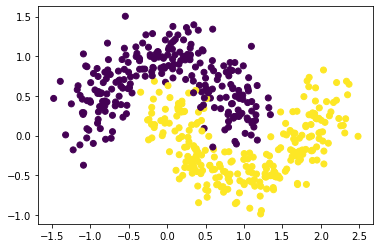

In [5]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [90]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
def score_check(moons_points, moons_labels, best_model) :
    y_pred = best_model.predict(moons_points)
    f1 = f1_score(moons_labels, y_pred, average='weighted')
    print(f"F1 Score: {f1:.4f}")
    y_prob = best_model.predict_proba(moons_points)[:,1]
    
    if len(list(set(moons_labels))) <= 2 : 
        auc = roc_auc_score(moons_labels, y_prob)
        print(f"AUC: {auc:.4f}")
    else :
        auc = None
    acc = accuracy_score(moons_labels, y_pred)
    print(f"Acuracy: {acc:.4f}")
    
    return acc ,auc ,f1

F1 Score: 0.8440
AUC: 0.9487
Acuracy: 0.8440


(0.844, 0.948704, 0.8439975039600633)

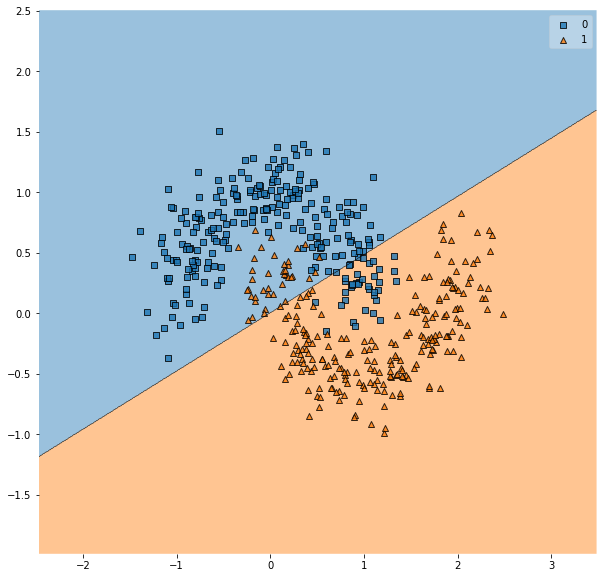

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
from mlxtend.plotting import plot_decision_regions

lr = LogisticRegression(solver='saga', tol=1e-3 ,C = 0.1  ) # add some params
svm = SVC(kernel='linear' , probability=True) # here too

### YOUR CODE HERE
plt.figure(figsize=(10,10))
lr.fit(moons_points, moons_labels)
plot_decision_regions(moons_points, moons_labels, lr)
score_check(moons_points, moons_labels, lr)

F1 Score: 0.8580
AUC: 0.9523
Acuracy: 0.8580


(0.858, 0.9523360000000001, 0.857985798579858)

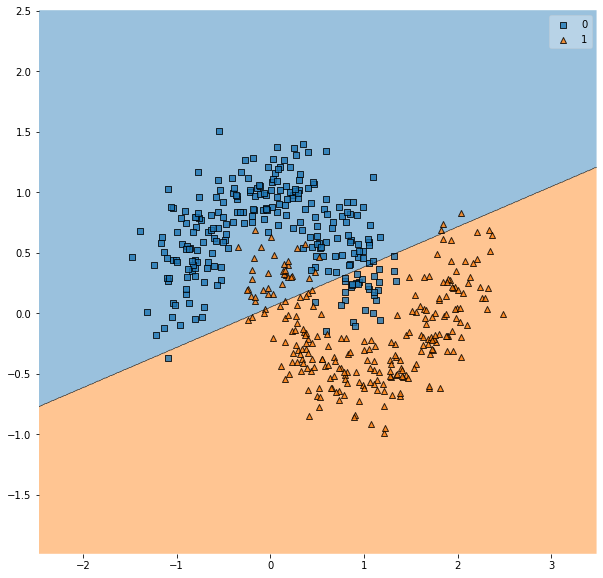

In [45]:
plt.figure(figsize=(10,10))
svm.fit(moons_points, moons_labels)
plot_decision_regions(moons_points, moons_labels, svm)
score_check(moons_points, moons_labels, svm)

## 1.2 Kernel tirck

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

{'gamma': 1, 'kernel': 'rbf'}
F1 Score: 0.9760
AUC: 0.9976
Acuracy: 0.9760


(0.976, 0.997568, 0.975999615993856)

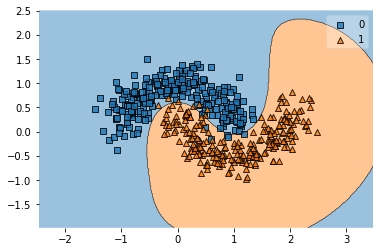

In [46]:
### YOUR CODE HERE

param_grid = [
    {'kernel': ['poly'], 'degree': [2, 3, 4]},
    {'kernel': ['rbf'], 'gamma': [0.1, 1, 10]},
    {'kernel': ['sigmoid'], 'gamma': [0.1, 1, 10]}
]

svm_model = SVC(probability=True)

grid_search = GridSearchCV(svm_model, param_grid, scoring='accuracy', cv=5)

# Fit the model
grid_search.fit(moons_points, moons_labels)

best_model = grid_search.best_estimator_
print(grid_search.best_params_)
plot_decision_regions(moons_points, moons_labels, best_model)
score_check(moons_points, moons_labels, best_model)

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

In [86]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

### YOUR CODE HERE

lr = LogisticRegression() # add some params
svm = SVC(gamma = 1, kernel='rbf', probability=True) # here too
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(moons_points)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_poly)

param_grid = {'C': [0.1, 1, 10,100], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 150, 200,500,1000]}


grid_search = GridSearchCV(lr, param_grid, scoring='f1_weighted', cv=5)

grid_search.fit(X_train_std, moons_labels )

best_params = grid_search.best_params_
print(best_params)
best_lr = grid_search.best_estimator_


svm.fit(moons_points,moons_labels)
print('SVM :')
score_check(moons_points, moons_labels, svm)
print('Log reg')
score_check(X_train_std, moons_labels, best_lr)



{'C': 100, 'max_iter': 100, 'solver': 'liblinear'}
SVM :
F1 Score: 0.9760
AUC: 0.9976
Acuracy: 0.9760
Log reg
F1 Score: 0.9840
AUC: 0.9992
Acuracy: 0.9840


(0.984, 0.9991519999999999, 0.9839997439959038)

После подбора гиперпараметров мы смогли побить SVM за счет преобразования признаков

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

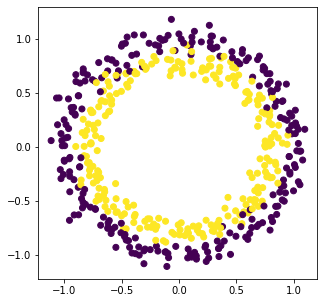

In [87]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

{'degree': 4, 'kernel': 'poly'}
F1 Score: 0.9380
AUC: 0.9859
Acuracy: 0.9380


(0.938, 0.9859040000000001, 0.9379977679196452)

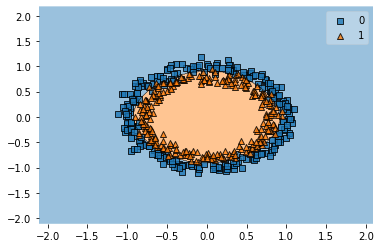

In [92]:
### YOUR CODE HERE
param_grid = [
    {'kernel': ['poly'], 'degree': [2, 3, 4]},
    {'kernel': ['rbf'], 'gamma': [0.1, 1, 10]},
    {'kernel': ['sigmoid'], 'gamma': [0.1, 1, 10]}
]

svm_model = SVC(probability=True)

grid_search = GridSearchCV(svm_model, param_grid, scoring='accuracy', cv=5)

# Fit the model
grid_search.fit(circles_points,circles_labels)

best_model = grid_search.best_estimator_
print(grid_search.best_params_)
plot_decision_regions(circles_points, circles_labels, best_model)
score_check(circles_points, circles_labels, best_model)

{'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}
F1 Score: 0.9420
AUC: 0.9852
Acuracy: 0.9420


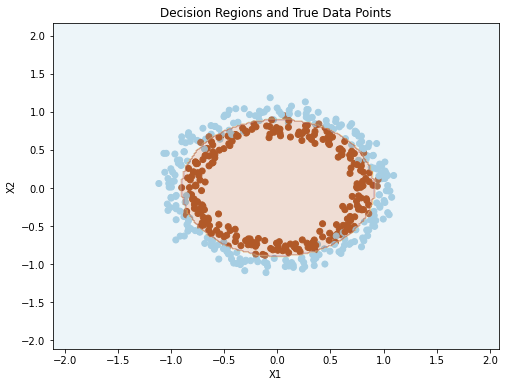

In [97]:
lr = LogisticRegression() 
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(circles_points)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_poly)
param_grid = {'C': [0.1, 1, 10,100], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 150, 200,500,1000]}
grid_search = GridSearchCV(lr, param_grid, scoring='f1_weighted', cv=5)
grid_search.fit(X_train_std, circles_labels )
best_params = grid_search.best_params_
print(best_params)
best_lr = grid_search.best_estimator_

score_check(X_train_std, circles_labels, best_lr)

y_pred_lr = best_lr.predict(X_train_std)

plt.figure(figsize=(8, 6))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels, cmap=plt.cm.Paired, label="True Data")
h = .02  # step size in the mesh
x_min, x_max = circles_points[:, 0].min() - 1, circles_points[:, 0].max() + 1
y_min, y_max = circles_points[:, 1].min() - 1, circles_points[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = best_lr.predict(scaler.transform(poly.transform(np.c_[xx.ravel(), yy.ravel()])))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Regions and True Data Points')
plt.show()

And even more:

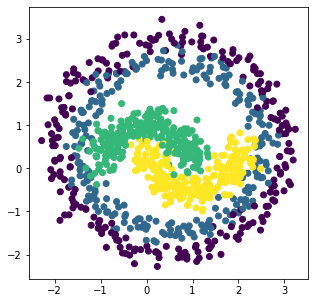

In [88]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

{'gamma': 1, 'kernel': 'rbf'}
F1 Score: 0.9351
Acuracy: 0.9350


(0.935, None, 0.9351236644519203)

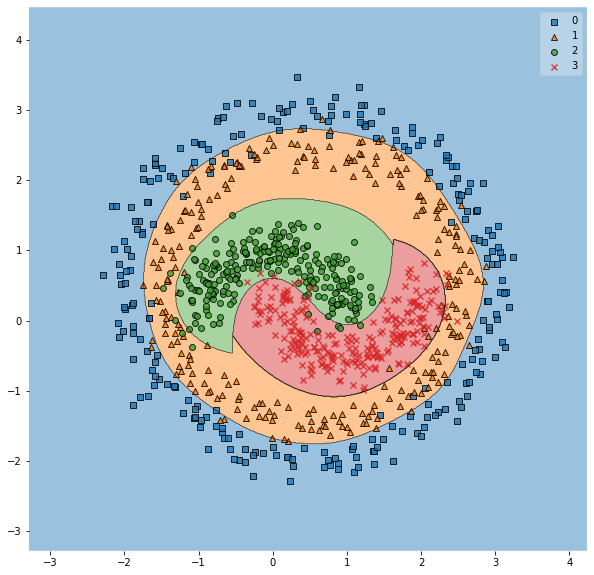

In [98]:
### YOUR CODE HERE
param_grid = [
    {'kernel': ['poly'], 'degree': [2, 3, 4]},
    {'kernel': ['rbf'], 'gamma': [0.1, 1, 10]},
    {'kernel': ['sigmoid'], 'gamma': [0.1, 1, 10]}
]

svm_model = SVC(probability=True)

grid_search = GridSearchCV(svm_model, param_grid, scoring='accuracy', cv=5)

# Fit the model
grid_search.fit(points,labels)

best_model = grid_search.best_estimator_

plt.figure(figsize=(10,10))
print(grid_search.best_params_)
plot_decision_regions(points, labels, best_model)
score_check(points, labels, best_model)

{'C': 1000, 'max_iter': 1000, 'solver': 'saga'}
F1 Score: 0.9351
Acuracy: 0.9350


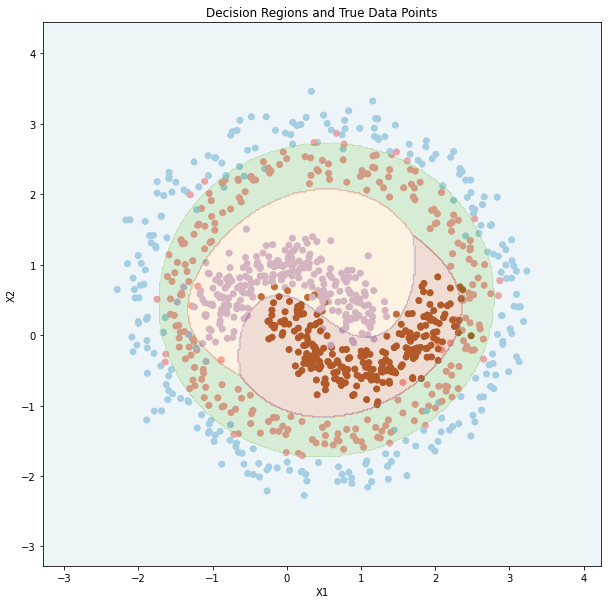

In [103]:
lr = LogisticRegression() 
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(points)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_poly)
param_grid = {'C': [1,100,1000], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 150, 200,500,1000]}
grid_search = GridSearchCV(lr, param_grid, scoring='f1_weighted', cv=5)
grid_search.fit(X_train_std, labels )
best_params = grid_search.best_params_
print(best_params)
best_lr = grid_search.best_estimator_

score_check(X_train_std, labels, best_lr)

y_pred_lr = best_lr.predict(X_train_std)

plt.figure(figsize=(10, 10))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap=plt.cm.Paired, label="True Data")
h = .02  # step size in the mesh
x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = best_lr.predict(scaler.transform(poly.transform(np.c_[xx.ravel(), yy.ravel()])))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Regions and True Data Points')
plt.show()

У нас получилось с помощью трансформации признаков и лог регрессии получить почти такую же картину по качеству и по графику как у svm 